In [115]:
import os
import random
import numpy as np
import pandas as pd
import patsy
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.regression.mixed_linear_model import MixedLMResults
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.power import TTestIndPower
!pip install bioinfokit
from bioinfokit.analys import stat
from scipy import stats
from scipy.stats import ttest_ind
import seaborn as sns
!pip install scikit_posthocs
import scikit_posthocs as sp
!pip install pingouin
import pingouin as pg
from pingouin import ancova
from pingouin import pairwise_ttests
!pip install dfply
from dfply import *
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode()

import warnings
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

/tmp/ipykernel_50/2275458743.py:32: UserWarning:

DelftStack



# Data Cleaning 

## read in data set


In [2]:
dataset = pd.read_csv('~/data/diabetes.csv')
dataset.head()


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

## Clean the Dataset

In [3]:
# let's understand the # of rows and columns. Loos like 768 rows, 9 columnes (pre-cleaning)
dataset.shape

(768, 9)

In [4]:
# all the data types are integers
dataset.dtypes


Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [5]:
# any missing values? Doesn't look like it
def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
    
    if total == 0:
        print("no missing values left")
            
missing_cols(dataset)

no missing values left


### Descriptive statistics table with central tendency

In [6]:
# So it doesn't look like there are any missing values/NaNs otherwise they would be counted
# However, when we look at the dataset description, there are minimum values of 0 in Glucose, BloodPressure, SkinThickness, Insulin, BMI
# that doesn't make contextual sense. 
dataset.describe()


Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [7]:
# Let's look at how many zero values there are per column
# formula for counting number of zeros in all columns of Dataframe
for column_name in dataset.columns:
    column = dataset[column_name]
    count = (column == 0).sum()
    print('Count of zeros in column ', column_name, ' is : ', count)


Count of zeros in column  Pregnancies  is :  111
Count of zeros in column  Glucose  is :  5
Count of zeros in column  BloodPressure  is :  35
Count of zeros in column  SkinThickness  is :  227
Count of zeros in column  Insulin  is :  374
Count of zeros in column  BMI  is :  11
Count of zeros in column  DiabetesPedigreeFunction  is :  0
Count of zeros in column  Age  is :  0
Count of zeros in column  Outcome  is :  500


In [8]:
# the zeroes don't make sense in the variables for Glucose, BloodPressure, SkinThickness, Insulin, BMI
# this is because a zero-value there is biologically implausible.
# However, these values don't seem to represent a measurement error or data entry error - it's not immediately correctable.
# We shouldn't delete them as this data is a part of the population and also the overall population size is small. 
# Previous research using this data set has shown that a small concentration of disguised missing values can have serious consequences and these are missing metadata. 
# Despite this and understanding this limitation, for the purposes of this project, I decide to impute them simply.


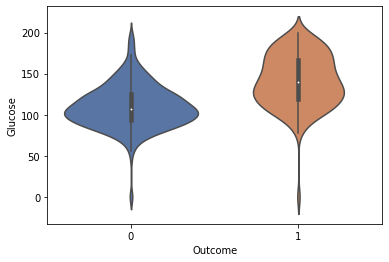

In [9]:
# Classifying the Glucose based on class
ax = sns.violinplot(x='Outcome', y='Glucose', data=dataset, palette='deep', split=True)

In [10]:
# Replace the zero-values for Glucose such that glucose values are replaced by the median glucose value of all those who had diabetes or those who did not have diabetes
df1 = dataset.loc[dataset['Outcome'] == 1]
df2 = dataset.loc[dataset['Outcome'] == 0]
df1 = df1.replace({'Glucose':0}, np.median(df1['BloodPressure']))
df2 = df2.replace({'Glucose':0}, np.median(df2['BloodPressure']))
tempdataframe = [df1, df2]
dataset = pd.concat(tempdataframe)

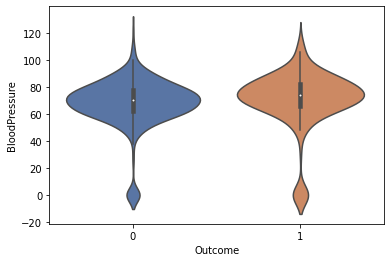

In [11]:
#Classifying the Blood Pressure based on class
ax = sns.violinplot(x='Outcome', y='BloodPressure', data=dataset, palette='deep', split=True)

In [12]:
#Replacing the zero-values for Blood Pressure
df1 = dataset.loc[dataset['Outcome'] == 1]
df2 = dataset.loc[dataset['Outcome'] == 0]
df1 = df1.replace({'BloodPressure':0}, np.median(df1['BloodPressure']))
df2 = df2.replace({'BloodPressure':0}, np.median(df2['BloodPressure']))
dataframe = [df1, df2]
dataset = pd.concat(dataframe)

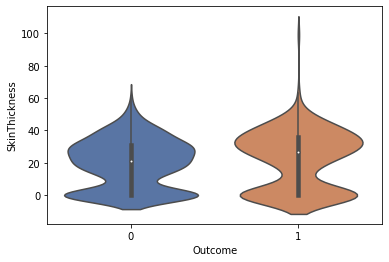

In [13]:
#Classifying the SkinThickness based on class
ax = sns.violinplot(x='Outcome', y='SkinThickness', data=dataset, palette='deep', split=True)

In [14]:
# SkinThickness has a LOT of zero values.
# Replacing the zero-values for SkinThickness
df1 = dataset.loc[dataset['Outcome'] == 1]
df2 = dataset.loc[dataset['Outcome'] == 0]
df1 = df1.replace({'SkinThickness':0}, np.median(df1['BloodPressure']))
df2 = df2.replace({'SkinThickness':0}, np.median(df2['BloodPressure']))
dataframe = [df1, df2]
dataset = pd.concat(dataframe)

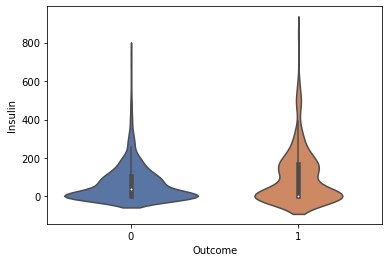

In [15]:
#Classifying the Insulin based on class
ax = sns.violinplot(x='Outcome', y='Insulin', data=dataset, palette='deep', split=True)

In [16]:
#Replacing the zero-values for Insulin
df1 = dataset.loc[dataset['Outcome'] == 1]
df2 = dataset.loc[dataset['Outcome'] == 0]
df1 = df1.replace({'Insulin':0}, np.median(df1['BloodPressure']))
df2 = df2.replace({'Insulin':0}, np.median(df2['BloodPressure']))
dataframe = [df1, df2]
dataset = pd.concat(dataframe)

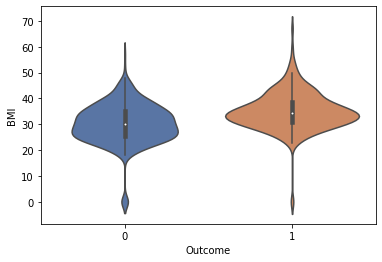

In [17]:
#Classifying the BMI based on class
ax = sns.violinplot(x='Outcome', y='BMI', data=dataset, palette='deep', split=True)

In [18]:
#Replacing the zero-values for BMI
df1 = dataset.loc[dataset['Outcome'] == 1]
df2 = dataset.loc[dataset['Outcome'] == 0]
df1 = df1.replace({'BMI':0}, np.median(df1['BloodPressure']))
df2 = df2.replace({'BMI':0}, np.median(df2['BloodPressure']))
dataframe = [df1, df2]
dataset = pd.concat(dataframe)

# Exploratory Data Analysis

## Univariate EDA

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

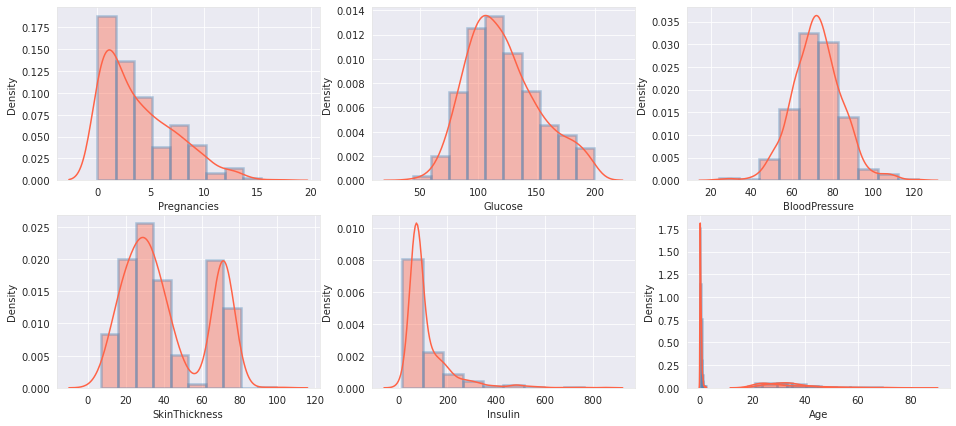

In [19]:
# Histograms for all attributes except Outcome (binary response attribute)

sns.set_style('darkgrid',{'axes.edgecolor': '.9'},)
f, ax = plt.subplots(2,3,figsize = (16,7))
plt.rcParams["patch.force_edgecolor"] = True

vis1 = sns.distplot(dataset["Pregnancies"],bins=10,color='tomato', hist_kws=dict(edgecolor="steelblue", linewidth=2.5),ax= ax[0][0])
vis2 = sns.distplot(dataset["Glucose"],bins=10,color='tomato', hist_kws=dict(edgecolor="steelblue",linewidth=2.5),ax=ax[0][1])
vis3 = sns.distplot(dataset["BloodPressure"],bins=10,color='tomato', hist_kws=dict(edgecolor="steelblue", linewidth=2.5),ax=ax[0][2])
vis4 = sns.distplot(dataset["SkinThickness"],bins=10,color='tomato', hist_kws=dict(edgecolor="steelblue", linewidth=2.5), ax=ax[1][0])
vis5 = sns.distplot(dataset["Insulin"],bins=10,color='tomato', hist_kws=dict(edgecolor="steelblue", linewidth=2.5),ax=ax[1][1])
vis6 = sns.distplot(dataset["BMI"],bins=10,color='tomato', hist_kws=dict(edgecolor="steelblue", linewidth=2.5),ax=ax[1][2])
vis7 = sns.distplot(dataset["DiabetesPedigreeFunction"],bins=10,color='tomato', hist_kws=dict(edgecolor="steelblue", linewidth=2.5),ax=ax[1][2])
vis8 = sns.distplot(dataset["Age"],bins=5,color='tomato', hist_kws=dict(edgecolor="steelblue", linewidth=2.5),ax=ax[1][2])


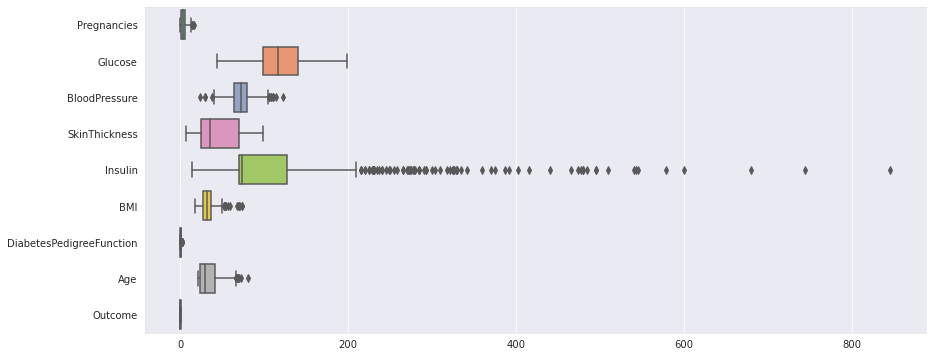

In [20]:
# Boxplots for all attributes 
plt.figure(figsize=(14,6))
ax = sns.boxplot(data=dataset, orient="h", palette="Set2")

In [21]:
# notes on univariate EDA:
# SkinThickness appears to be bimodal
# Insulin, Age, Blood Pressure, BMI variables appear to have many outliers.

# Multivariate EDA

### Checking for correlation between all pairs of attributes (multicollinearity)

In [22]:
# Correlation matrix for all pairs of attributes
# A correlation of -1 or 1 shows a full negative or positive correlation.
# A value of 0 shows no correlation at all.

correlations = dataset.corr(method ='pearson')
print(correlations)

                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.130373       0.209155       0.176010   
Glucose                      0.130373  1.000000       0.225715       0.131223   
BloodPressure                0.209155  0.225715       1.000000       0.189075   
SkinThickness                0.176010  0.131223       0.189075       1.000000   
Insulin                     -0.023396  0.397567       0.001450      -0.208964   
BMI                          0.021155  0.154220       0.246257       0.184821   
DiabetesPedigreeFunction    -0.033523  0.138974      -0.001336      -0.096524   
Age                          0.544341  0.268720       0.325306       0.255659   
Outcome                      0.221898  0.487944       0.173316       0.164425   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.023396  0.021155                 -0.033523   
Glucose                   0.397567  0.154

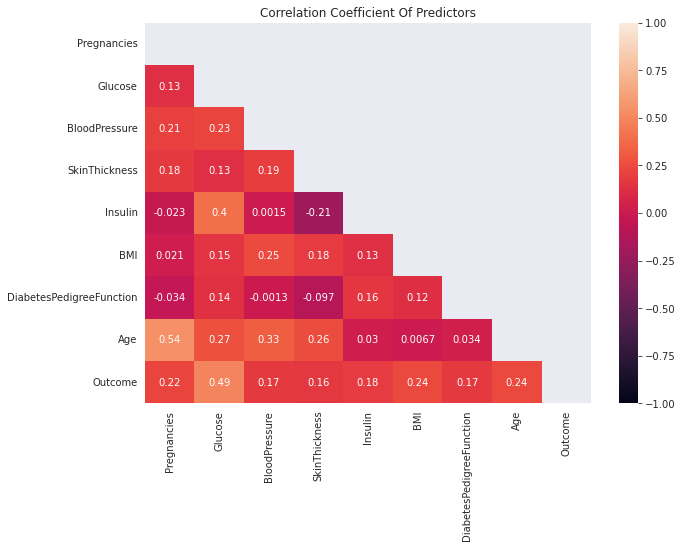

In [23]:
# Heatmap for the correlation matrix above
plt.figure(figsize=(10,7))
mask = np.triu(np.ones_like(dataset.corr(), dtype=bool))
sns.heatmap(dataset.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()


In [24]:
# notes on multivariate EDA:
# Looks like Insulin, BMI, and DiabetesPedigreeFunction are so far the least correlated values 
# Also no significant case of multi-collinearity is observed (no correlation coefficients or r above 0.5).


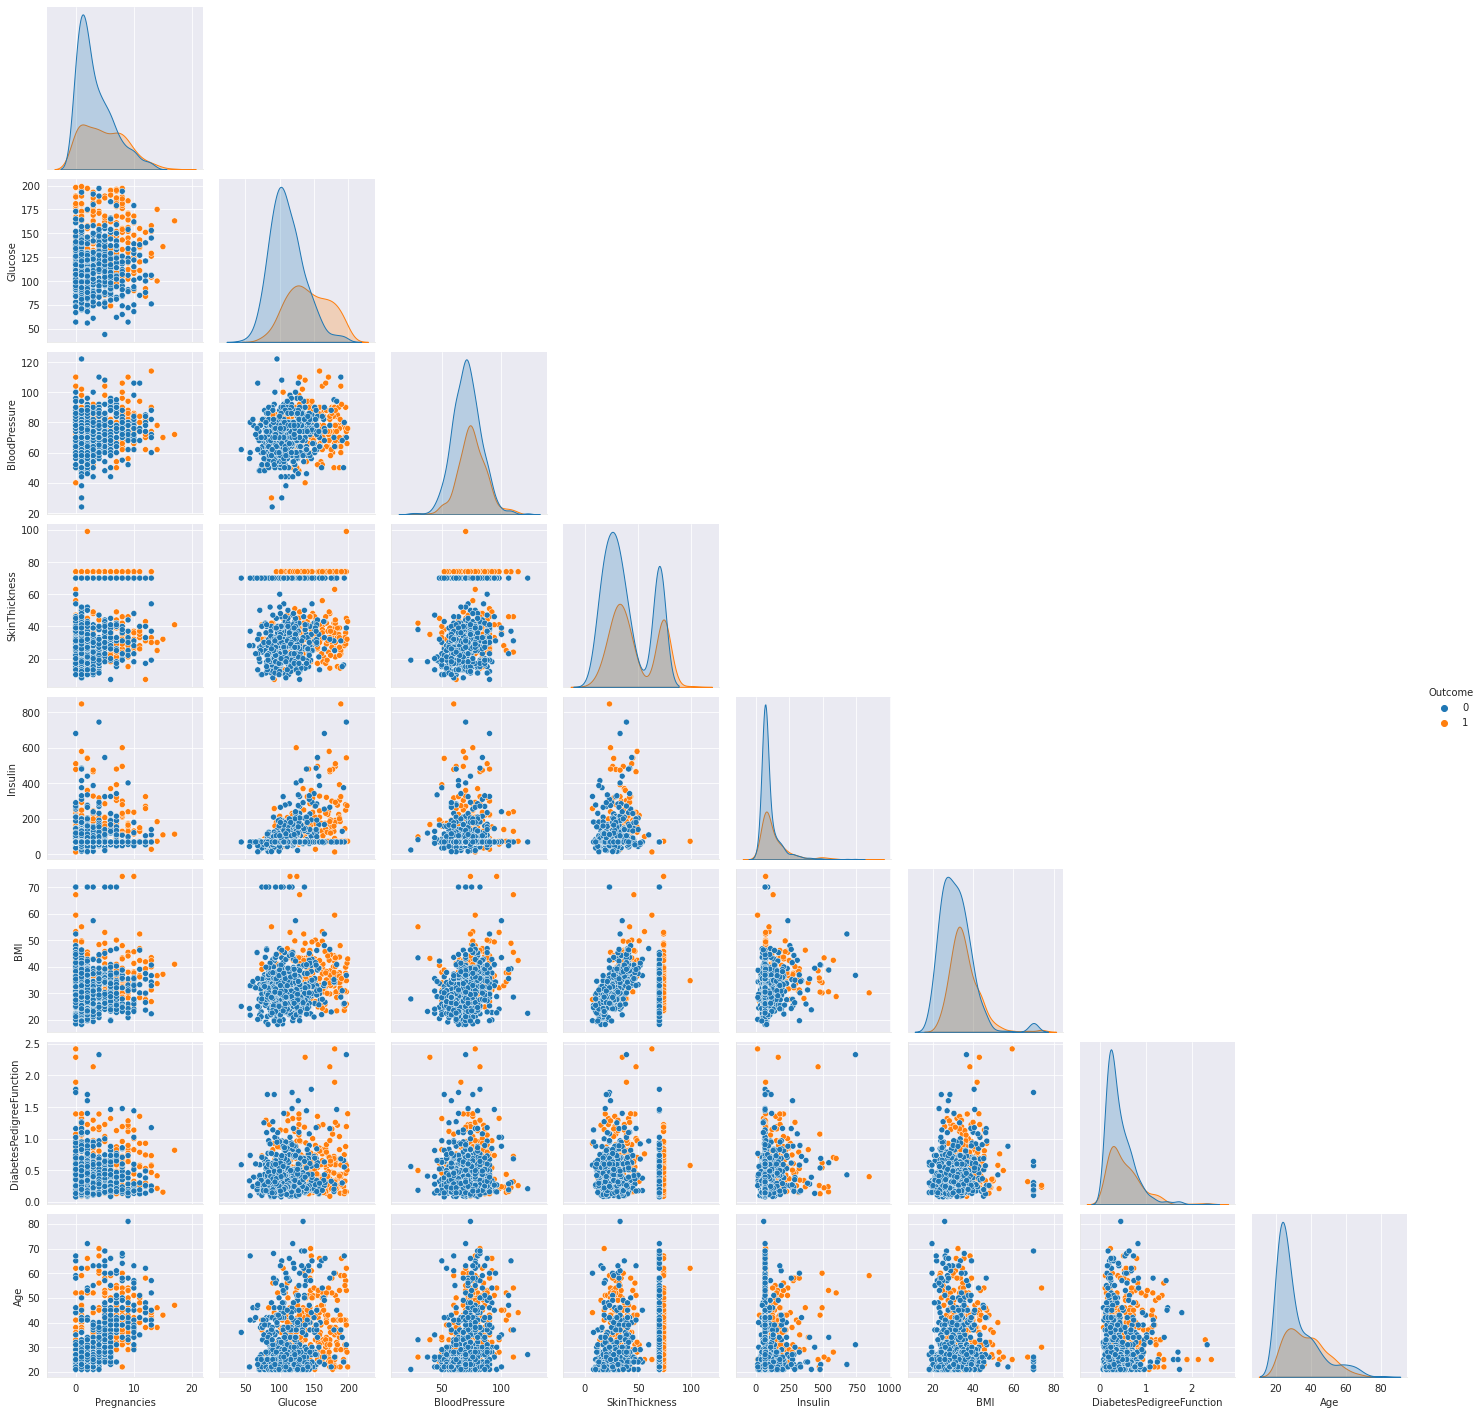

In [25]:
# Scatterplot for every pair of attributes
# This would help spot structured relationships between attributes.
# Attributes with structured relationships may also be correlated, and good candidates for removal from the dataset.
# Using the outcome attribute as a hue.
sns.pairplot(dataset, hue="Outcome",  corner=True)

# Independent T-Tests

### Blood Pressure and Skin Thickness vs Diabetes (No Statistical Difference)

In [26]:
# BloodPressure on Outcome
# Interpretation:
# There is no statistically significant difference in the average Blood Pressure between non-diabetics and diabetics
# t= -4.87, p= 1.8e-06.

stats.ttest_ind(dataset['BloodPressure'][dataset['Outcome'] == 0],
                dataset['BloodPressure'][dataset['Outcome'] == 1])

Ttest_indResult(statistic=-4.870517357854915, pvalue=1.3526640033068188e-06)

Text(0.5, 0, 'Outcome (0 = Non-Diabetic, 1 = Diabetic)')

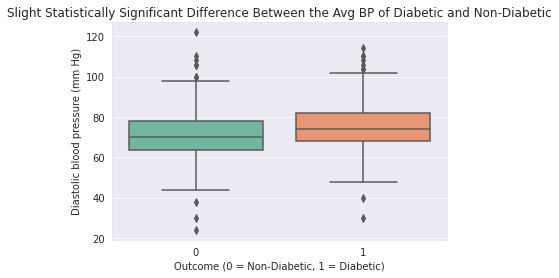

In [27]:
# Visualize BloodPressure on Outcome
ax = sns.boxplot(x="Outcome", y="BloodPressure", data=dataset, palette="Set2")
ax.set_title('Slight Statistically Significant Difference Between the Avg BP of Diabetic and Non-Diabetic'),
ax.set_ylabel('Diastolic blood pressure (mm Hg)')
ax.set_xlabel('Outcome (0 = Non-Diabetic, 1 = Diabetic)')

In [28]:
# SkinThickness on Outcome
# Interpretation:
# There is no statistically significant difference in the average skin thickness between non-diabetics and diabetics
# t= -4.61, p= 4.6e-06.
stats.ttest_ind(dataset['SkinThickness'][dataset['Outcome'] == 0],
                dataset['SkinThickness'][dataset['Outcome'] == 1])

Ttest_indResult(statistic=-4.613548469712124, pvalue=4.639075362467778e-06)

Text(0.5, 0, 'Outcome (0 = Non-Diabetic, 1 = Diabetic)')

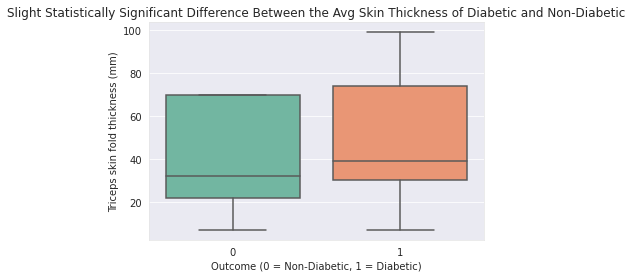

In [29]:
# Visualize SkinThickness on Outcome
ax = sns.boxplot(x="Outcome", y="SkinThickness", data=dataset, palette="Set2")
ax.set_title('Slight Statistically Significant Difference Between the Avg Skin Thickness of Diabetic and Non-Diabetic'),
ax.set_ylabel('Triceps skin fold thickness (mm)')
ax.set_xlabel('Outcome (0 = Non-Diabetic, 1 = Diabetic)')

### Pregnancy, Diabetes Pedigree Function, and Insulin vs Diabetes (Slight Statistical Difference)

In [30]:
# Pregnancies on Outcome
# There is a slight statistically significant difference in the average # of pregnancies between non-diabetics and diabetics
# t= -6.30, p= 5.6e-10.
stats.ttest_ind(dataset['Pregnancies'][dataset['Outcome'] == 0],
                dataset['Pregnancies'][dataset['Outcome'] == 1])

Ttest_indResult(statistic=-6.298430550035151, pvalue=5.065127298053476e-10)

Text(0.5, 0, 'Outcome (0 = Non-Diabetic, 1 = Diabetic)')

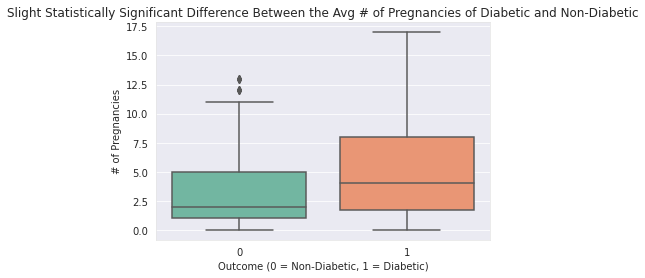

In [31]:
# Visualize Pregnancies on Outcome
ax = sns.boxplot(x="Outcome", y="Pregnancies", data=dataset, palette="Set2")
ax.set_title('Slight Statistically Significant Difference Between the Avg # of Pregnancies of Diabetic and Non-Diabetic'),
ax.set_ylabel('# of Pregnancies')
ax.set_xlabel('Outcome (0 = Non-Diabetic, 1 = Diabetic)')

In [32]:
# Diabetes Pedigree Function on Outcome
# There is a slight statistically significant difference in the average Diabetes Pedigree Function between non-diabetics and diabetics
# t= -4.89, p= 1.21e-06.
stats.ttest_ind(dataset['DiabetesPedigreeFunction'][dataset['Outcome'] == 0],
                dataset['DiabetesPedigreeFunction'][dataset['Outcome'] == 1])


Ttest_indResult(statistic=-4.88582646072744, pvalue=1.254607010148809e-06)

Text(0.5, 0, 'Outcome (0 = Non-Diabetic, 1 = Diabetic)')

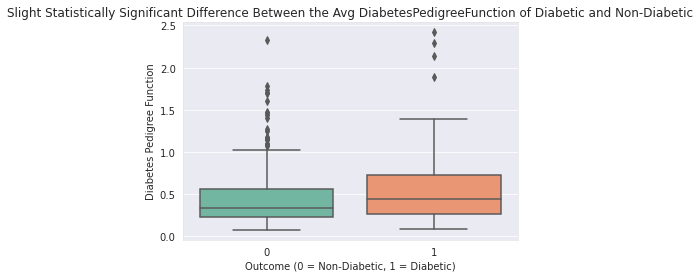

In [33]:
# Visualize DiabetesPedigreeFunction on Outcome
ax = sns.boxplot(x="Outcome", y="DiabetesPedigreeFunction", data=dataset, palette="Set2")
ax.set_title('Slight Statistically Significant Difference Between the Avg DiabetesPedigreeFunction of Diabetic and Non-Diabetic'),
ax.set_ylabel('Diabetes Pedigree Function')
ax.set_xlabel('Outcome (0 = Non-Diabetic, 1 = Diabetic)')

In [34]:
# Insulin on Outcome
# Interpretation:
# There is a slightly statistically significant difference in the average insulin concentration between non-diabetics and diabetics
# t= -5.18, p= 2.8e-07.

stats.ttest_ind(dataset['Insulin'][dataset['Outcome'] == 0],
                dataset['Insulin'][dataset['Outcome'] == 1])

Ttest_indResult(statistic=-5.18282047891269, pvalue=2.798207641633437e-07)

Text(0.5, 0, 'Outcome (0 = Non-Diabetic, 1 = Diabetic)')

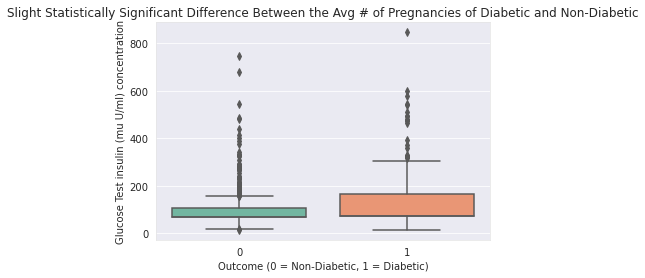

In [35]:
# Visualize Insulin on Outcome
ax = sns.boxplot(x="Outcome", y="Insulin", data=dataset, palette="Set2")
ax.set_title('Slight Statistically Significant Difference Between the Avg # of Pregnancies of Diabetic and Non-Diabetic'),
ax.set_ylabel('Glucose Test insulin (mu U/ml) concentration')
ax.set_xlabel('Outcome (0 = Non-Diabetic, 1 = Diabetic)')

### Glucose Concentration, BMI, Age vs Diabetes  (Statistical Difference)

In [36]:
# Glucose on Outcome
# There is a strong statistically significant difference in the average glucose concentration between non-diabetics and diabetics
# t= -15.47, p= 3.47e-47.
stats.ttest_ind(dataset['Glucose'][dataset['Outcome'] == 0],
                dataset['Glucose'][dataset['Outcome'] == 1])

Ttest_indResult(statistic=-15.471485239228487, pvalue=3.458071403604558e-47)

Text(0.5, 0, 'Outcome (0 = Non-Diabetic, 1 = Diabetic)')

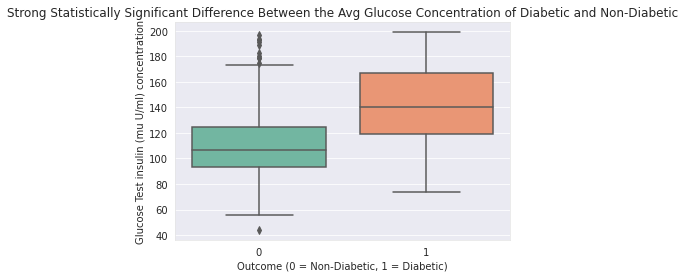

In [37]:
# Visualize Glucose on Outcome
ax = sns.boxplot(x="Outcome", y='Glucose', data=dataset, palette="Set2")
ax.set_title('Strong Statistically Significant Difference Between the Avg Glucose Concentration of Diabetic and Non-Diabetic'),
ax.set_ylabel('Glucose Test insulin (mu U/ml) concentration')
ax.set_xlabel('Outcome (0 = Non-Diabetic, 1 = Diabetic)')

In [38]:
# BMI on Outcome
# There is a strong statistically significant difference in the average BMI between non-diabetics and diabetics
# t= -6.80, p= 1.99e-11.
stats.ttest_ind(dataset['BMI'][dataset['Outcome'] == 0],
                dataset['BMI'][dataset['Outcome'] == 1])

Ttest_indResult(statistic=-6.809078113676607, pvalue=1.985128000511279e-11)

Text(0.5, 0, 'Outcome (0 = Non-Diabetic, 1 = Diabetic)')

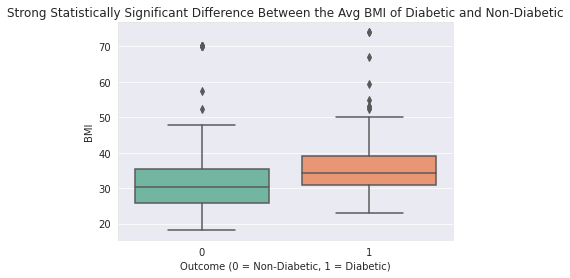

In [39]:
# Visualize BMI on Outcome
ax = sns.boxplot(x="Outcome", y="BMI", data=dataset, palette="Set2")
ax.set_title('Strong Statistically Significant Difference Between the Avg BMI of Diabetic and Non-Diabetic'),
ax.set_ylabel('BMI')
ax.set_xlabel('Outcome (0 = Non-Diabetic, 1 = Diabetic)')

In [40]:
# Age on Outcome
# There is a slight statistically significant difference in the average age between non-diabetics and diabetics
# t= -6.79, p= 2.21e-11.
stats.ttest_ind(dataset['Age'][dataset['Outcome'] == 0],
                dataset['Age'][dataset['Outcome'] == 1])

Ttest_indResult(statistic=-6.792688071649956, pvalue=2.2099754606654358e-11)

Text(0.5, 0, 'Outcome (0 = Non-Diabetic, 1 = Diabetic)')

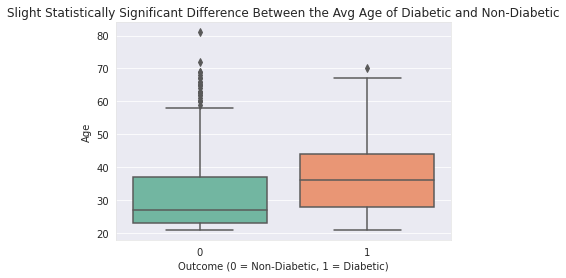

In [41]:
# Visualize Age on Outcome
ax = sns.boxplot(x="Outcome", y="Age", data=dataset, palette="Set2")
ax.set_title('Slight Statistically Significant Difference Between the Avg Age of Diabetic and Non-Diabetic'),
ax.set_ylabel('Age')
ax.set_xlabel('Outcome (0 = Non-Diabetic, 1 = Diabetic)')

# Linear Regression Modeling

In [42]:
# Purpose: to estimate parameters?
# Hypothesizing that both glucose and BMI will be good predictors of diabetes and that both will have small p-values and the largest effect sizes of all variables.

In [43]:
# Turn BMI into a categorical variable with the following levels: "Underweight/Normal BMI", "Overweight BMI", "Obese BMI"
df=dataset[['BMI','Glucose', 'Outcome']]
df.head()
df['BMI'] = pd.cut(x=df['BMI'], bins=[18, 24.9, 29.9, 50],
                     labels=['Underweight or Normal BMI','Overweight BMI','Obese BMI'])
  
# Printing DataFrame after sorting Continuous to
# Categories
print("After: ")
print(df)
  
# Check the number of values in each bin
print("Categories: ")
print(df['BMI'].value_counts())

After: 
                           BMI  Glucose  Outcome
0                    Obese BMI      148        1
2    Underweight or Normal BMI      183        1
4                    Obese BMI      137        1
6                    Obese BMI       78        1
8                    Obese BMI      197        1
..                         ...      ...      ...
762  Underweight or Normal BMI       89        0
763                  Obese BMI      101        0
764                  Obese BMI      122        0
765             Overweight BMI      121        0
767                  Obese BMI       93        0

[768 rows x 3 columns]
Categories: 
Obese BMI                    464
Overweight BMI               179
Underweight or Normal BMI    106
Name: BMI, dtype: int64


/tmp/ipykernel_50/2715063052.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BMI'] = pd.cut(x=df['BMI'], bins=[18, 24.9, 29.9, 50],


In [44]:
# separate outcome variable with predictor variables
X = df.iloc[:, :-1].values
y = df.iloc[:, 1].values

# One-Way ANOVA

In [45]:
# This is to test if the means are equal for more than two groups we perform an analysis of variance test.
# An ANOVA test will determine if the grouping variable explains a significant portion of the variability in the dependent variable. 
# If so, we would expect that the mean of your dependent variable will be different in each group. 

<AxesSubplot:xlabel='Outcome', ylabel='Glucose'>

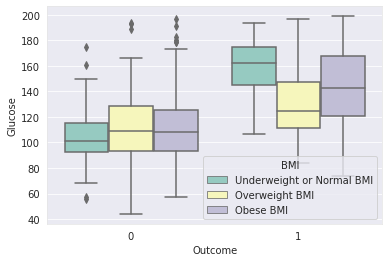

In [46]:
# based on the box plot looking at the effect of Glucose and BMI on Outcome
# the means are not equal for more than two groups
sns.boxplot(x="Outcome", y="Glucose", hue="BMI", data=df, palette="Set3")

In [47]:
# generate fit model to data to obtain parameter estimates
lm = smf.ols('Glucose ~ BMI', data=df).fit()


In [48]:
# print summary of linear regression
(lm.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Glucose   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     18.59
Date:                Tue, 12 Apr 2022   Prob (F-statistic):           1.33e-08
Time:                        20:16:51   Log-Likelihood:                -3610.2
No. Observations:                 749   AIC:                             7226.
Df Residuals:                     746   BIC:                             7240.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               108.1604      2.919     37.049      0.000     102.429     113.892
BMI[T.Overweight BMI]     8.5771      3.684      2.328      0.020       1.345      15.809
BMI[T.Obese BMI]         18.1327      3.236      5.604      0.000      11.781      24.485
==============================================================================
Omnibus:                       26.044   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.559
Skew:                           0.453   Prob(JB):                     1.04e-06
Kurtosis:                       2.752   Cond. No.                         5.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# Let's look at the Anova table
# Show Anova table
# The table seems to show that significant differences in group means are obtained for all group pairs (1.333-08).

anova_table = sm.stats.anova_lm(lm, typ=2)
print(anova_table)

                 sum_sq     df          F        PR(>F)
BMI        33579.767717    2.0  18.585252  1.327927e-08
Residual  673935.070734  746.0        NaN           NaN


In [50]:
# The results tell us that there is a significant difference between groups means between BMI and Glucose (p = 1.33e-08)
# but does not tell us the exact group pairs which are different in means. 

In [51]:
# To obtain pairwise group differences, we will carry out a posteriori (post hoc) analysis using Bonferroni procedure, when making multiple comparisons.

pair_t = lm.t_test_pairwise('BMI')
pair_t.result_frame


# Result: we fail to reject the null hypothesis that the variance in glucose is equal to the variance in glucose for non-diabetics 
# The means of our dependent variable is different in each group.

coef   std err         t  \
Overweight BMI-Underweight or Normal BMI   8.577053  3.683686  2.328389   
Obese BMI-Underweight or Normal BMI       18.132726  3.235677  5.603998   
Obese BMI-Overweight BMI                   9.555673  2.644598  3.613281   

                                                 P>|t|  Conf. Int. Low  \
Overweight BMI-Underweight or Normal BMI  2.015785e-02        1.345428   
Obese BMI-Underweight or Normal BMI       2.948368e-08       11.780610   
Obese BMI-Overweight BMI                  3.226317e-04        4.363934   

                                          Conf. Int. Upp.     pvalue-hs  \
Overweight BMI-Underweight or Normal BMI        15.808677  2.015785e-02   
Obese BMI-Underweight or Normal BMI             24.484842  8.845104e-08   
Obese BMI-Overweight BMI                        14.747413  6.451592e-04   

                                          reject-hs  
Overweight BMI-Underweight or Normal BMI       True  
Obese BMI-Underweight or Normal BMI            True  
Obese BMI-Overweight BMI                       True

# Two-Way ANOVA

In [52]:
# A two-way ANOVA is used to estimate how the mean of a quantitative variable changes according to the levels of two categorical variables. Use a two-way ANOVA when you want to know how two independent variables, in combination, affect a dependent variable.
model = smf.ols('Glucose ~ C(BMI) + C(Outcome) + C(BMI):C(Outcome)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq     df           F        PR(>F)
C(BMI)               3227.157877    2.0    2.279394  1.030614e-01
C(Outcome)         140210.742879    1.0  198.066284  4.731286e-40
C(BMI):C(Outcome)    7756.051645    2.0    5.478226  4.347183e-03
Residual           525968.276210  743.0         NaN           NaN

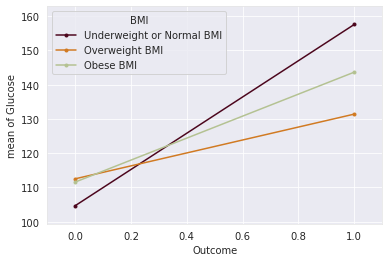

In [53]:
#interaction plot
fig = interaction_plot(x=df['Outcome'], trace=df['BMI'], response=df['Glucose'], 
    colors=['#4c061d','#d17a22', '#b4c292'])
plt.show()

# From the interaction plot, the interaction effect is significant between the Genotype and years because three lines are not parallel
# (roughly parallel factor lines indicate no interaction) and in fact they intersect and almost fully reverse. 

In [54]:
#post hoc test for main effect Outcome
res = stat()
res.tukey_hsd(df=df, res_var='Glucose', xfac_var='Outcome', anova_model='Glucose~C(Outcome)+C(BMI)+C(Outcome):C(BMI)')
res.tukey_summary.head()

/opt/conda/lib/python3.8/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


group1  group2       Diff     Lower      Upper    q-value  p-value
0       1       0  31.698789  27.68974  35.707837  21.951919    0.001

In [55]:
#post hoc test for main effect BMI
res.tukey_hsd(df=df, res_var='Glucose', xfac_var='BMI', anova_model='Glucose~C(Outcome)+C(BMI)+C(Outcome):C(BMI)')
res.tukey_summary.head()

/opt/conda/lib/python3.8/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


group1                     group2       Diff      Lower  \
0                  Obese BMI  Underweight or Normal BMI  18.132726  11.406109   
1                  Obese BMI             Overweight BMI   9.555673   4.057845   
2  Underweight or Normal BMI             Overweight BMI   8.577053   0.919074   

       Upper   q-value   p-value  
0  24.859343  8.952972  0.001000  
1  15.053502  5.772593  0.001000  
2  16.235032  3.719844  0.023636

In [56]:
#interaction effect between Outcome and BMI
res.tukey_hsd(df=df, res_var='Glucose', xfac_var=['BMI','Outcome'], anova_model='Glucose ~ C(Outcome) + C(BMI) + C(Outcome):C(BMI)')
res.tukey_summary.head()

/opt/conda/lib/python3.8/site-packages/bioinfokit/analys.py:368: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


group1                          group2       Diff      Lower  \
0  (Obese BMI, 1)                  (Obese BMI, 0)  32.082150  25.000247   
1  (Obese BMI, 1)  (Underweight or Normal BMI, 1)  13.923541 -15.276951   
2  (Obese BMI, 1)  (Underweight or Normal BMI, 0)  38.981221  29.734504   
3  (Obese BMI, 1)             (Overweight BMI, 1)  12.247887  -0.851715   
4  (Obese BMI, 1)             (Overweight BMI, 0)  31.129902  22.841099   

       Upper    q-value   p-value  
0  39.164053  18.304622  0.001000  
1  43.124033   1.926668  0.722111  
2  48.227937  17.033942  0.001000  
3  25.347490   3.777899  0.082502  
4  39.418704  15.175159  0.001000

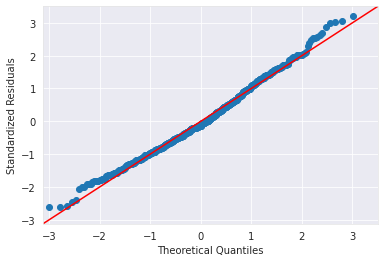

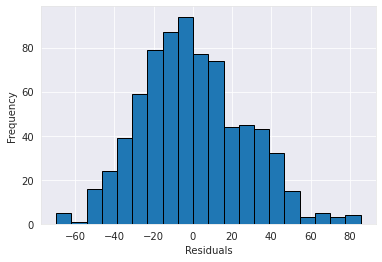

In [57]:
# check model assumptions with a QQ-plot
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [ ]:
# As the standardized residuals lie around the 45-degree line
# it suggests that the residuals are approximately normally distributed
# In the histogram,
# the distribution looks approximately normal and suggests that residuals are approximately normally distributed

In [58]:
# I then use Levene’s test to check the assumption of homogeneity of variances
res = stat()
res.levene(df=df, res_var='Glucose', xfac_var=['Outcome', 'BMI'])
res.levene_summary
# output
                 Parameter    Value
0      Test statistics (W)   1.6849
1  Degrees of freedom (Df)  17.0000
2                  p value   0.0927

IndentationError: unexpected indent (1622152110.py, line 7)

In [ ]:
# As the p value (0.09) is non-significant, we fail to reject the null hypothesis 
# and conclude that treatments have equal variances.

# One-Way ANCOVA

In [70]:
# Can we predict what the effect of BMI are on Outcome while controlling for Glucose levels?  
# Analysis of covariance is used to test the main and interaction effects of categorical variables on a continuous dependent variable,
# controlling for the effects of selected other continuous variables, which co-vary with the dependent. 
# So let's go back to the old version of BMI variable (without groups)

df2=dataset[['BMI','Glucose', 'Outcome']]
# summary statistics for dependent variable Glucose levels

df2 >> group_by(X.Outcome) >> summarize(n=X['BMI'].count(), mean=X['BMI'].mean(), std=X['BMI'].std())


Outcome    n       mean       std
0        0  500  31.564200  8.330679
1        1  268  35.694776  7.382668

In [71]:
# summary statistics for covariate Glucose
df2 >> group_by(X.Outcome) >> summarize(n=X['Glucose'].count(), mean=X['Glucose'].mean(), std=X['Glucose'].std())
# output


Outcome    n        mean        std
0        0  500  110.400000  24.901328
1        1  268  141.809701  30.070784

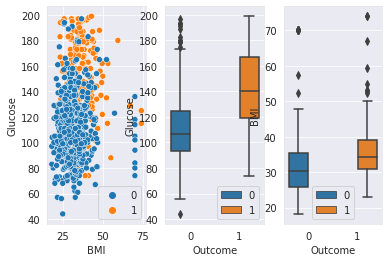

In [74]:
# Visualize dataset
fig, axs = plt.subplots(ncols=3)
sns.scatterplot(data=df2, x="BMI", y="Glucose", hue=df2.Outcome.tolist(), ax=axs[0])
sns.boxplot(data=df2, x="Outcome", y="Glucose", hue=df2.Outcome.tolist(), ax=axs[1])
sns.boxplot(data=df2, x="Outcome", y="BMI", hue=df2.Outcome.tolist(), ax=axs[2])
plt.show()

In [75]:
ancova(data=df2, dv='Glucose', covar='BMI', between='Outcome')

Source             SS   DF           F         p-unc       np2
0   Outcome  156027.230290    1  217.111938  1.925988e-43  0.221066
1       BMI    1086.973586    1    1.512524  2.191324e-01  0.001973
2  Residual  549766.321190  765         NaN           NaN       NaN

In [ ]:
# ANCOVA results indicate that there are significant differences in 
# mean glucose levels [F(1, 765) = 217.11, p < 0.001] among Outcome (diabetics vs non-diabetics) 
# while controlling the effect of BMI.

# The covariate BMI is significant [F(1, 765) = 1.51, p < 0.001] suggesting it is an important predictor of glucose levels.


In [86]:
#post hoc tests for ANCOVA 
posthocs = pg.pairwise_ttests(dv='Glucose', between='Outcome', padjust='bonf', data=df2)
posthocs

Contrast  A  B  Paired  Parametric          T         dof alternative  \
0  Outcome  0  1   False        True -14.622254  465.681878   two-sided   

          p-unc       BF10    hedges  
0  4.061397e-40  2.499e+39 -1.170131

# Statistical Power

In [87]:
# estimate sample size via power analysis
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis
effect = 0.8
alpha = 0.05
power = 0.8
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result)


Sample Size: 25.525


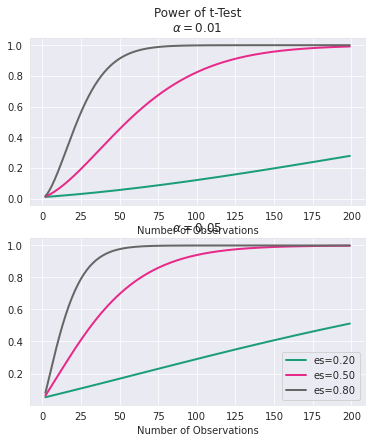

In [88]:
# power vs. number of observations 

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(2, 200),
                                 effect_size=np.array([0.2, 0.5, 0.8]),
                                 alpha=0.01,
                                 ax=ax, title='Power of t-Test' + '\n' + r'$\alpha = 0.01$')
ax.get_legend().remove()
ax = fig.add_subplot(2,1,2)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(2, 200),
                                 effect_size=np.array([0.2, 0.5, 0.8]),
                                 alpha=0.05,
                                 ax=ax, title=r'$\alpha = 0.05$') 
fig.subplots_adjust(top = 1.4)

In [104]:
# calculate the Cohen's d between two samples


In [106]:
df1 = dataset.loc[dataset['Outcome'] == 1]
df2 = dataset.loc[dataset['Outcome'] == 0]

In [107]:
# Cohen's d BMI
x = df1['BMI']
y = df2['BMI']
pg.compute_effsize(x, y, eftype='cohen')

0.5154855874344881

In [108]:
# Cohen's d Glucose
x = df1['Glucose']
y = df2['Glucose']
pg.compute_effsize(x, y, eftype='cohen')

1.1712786259579828

In [109]:
# Power Analysis BMI alpha 0.01
effect_size = 0.52
alpha = 0.01 # significance level
power = 0.8

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)

print('Required sample size for BMI: {0:.2f}'.format(sample_size))

Required sample size for BMI: 88.06


In [110]:
# Power Analysis BMI  alpha 0.05
effect_size = 0.52
alpha = 0.05 # significance level
power = 0.8

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)

print('Required sample size for BMI: {0:.2f}'.format(sample_size))

Required sample size for BMI: 59.03


In [112]:
# Power Analysis Glucose alpha 0.01
effect_size = 1.17
alpha = 0.01 # significance level
power = 0.8

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)

print('Required sample size for Glucose: {0:.2f}'.format(sample_size))

Required sample size for Glucose: 18.79


In [113]:
# Power Analysis Glucose  alpha 0.05
effect_size = 1.17
alpha = 0.05 # significance level
power = 0.8

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)

print('Required sample size for Glucose: {0:.2f}'.format(sample_size))

Required sample size for Glucose: 12.50


In [ ]:
# As the effect size increases, the required sample size decreases.

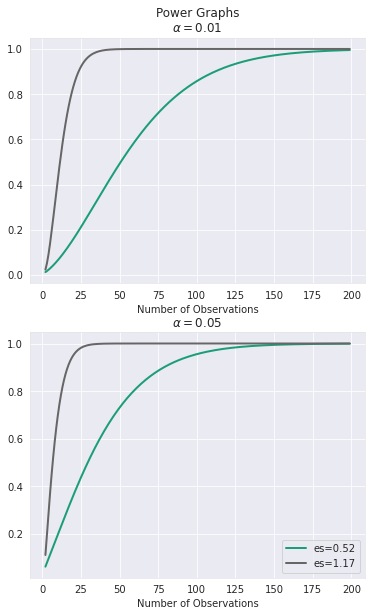

In [114]:
# power vs number of observations

fig = plt.figure()
ax = fig.add_subplot(2,1,1)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(2, 200),
                                 effect_size=np.array([0.52,1.17]),
                                 alpha=0.01,
                                 ax=ax, title='Power Graphs' + '\n' + r'$\alpha = 0.01$')
ax.get_legend().remove()
ax = fig.add_subplot(2,1,2)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(2, 200),
                                 effect_size=np.array([0.52,1.17]),
                                 alpha=0.05,
                                 ax=ax, title=r'$\alpha = 0.05$') 
fig.subplots_adjust(top = 2)

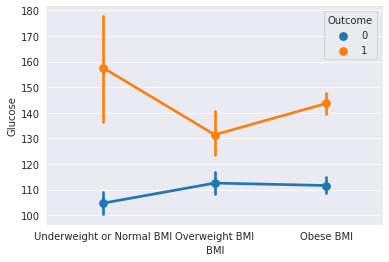

In [116]:
ax = sns.pointplot(x="BMI", y="Glucose", hue="Outcome",
                    data=df)

In [117]:
@np.vectorize
def power_grid(x,y):
    power = TTestIndPower().solve_power(effect_size = x, 
                                        nobs1 = y, 
                                        alpha = 0.05)
    return power

X,Y = np.meshgrid(np.linspace(0.01, 1, 51), 
                  np.linspace(10, 1000, 100))
X = X.T
Y = Y.T

Z = power_grid(X, Y) # power

data = [Surface(x = X, y= Y, z = Z)]

layout = Layout(
    title='Power Analysis',
    scene = dict(xaxis = dict(title='effect size'),
                 yaxis = dict(title='number of observations'),
                 zaxis = dict(title='power'),)
)

fig = Figure(data=data, layout=layout)
iplot(fig)